In this notebook we show the usage of the package `ApApproximation.jl`, based on the results exposed in the paper _Almost-periodic interpolation and approximation_ by J.-P. Gauthier and D. Prandi.

In [1]:
workspace()

push!(LOAD_PATH, "./../src/")

using Images, TestImages, ImageMagick
using ApApproximation

We will use the following image for the tests.

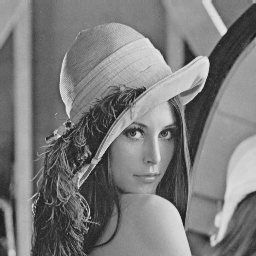

In [2]:
img = testimage("lena_gray_256") |> x->convert(Array{Float64,2}, data(x))
convert(Image, img)

Since we will deal with polar representations, we will actually only consider the central circle.

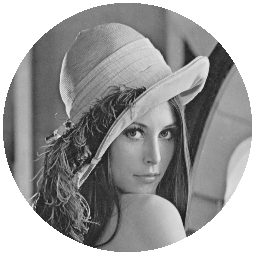

In [3]:
circle(i,j) = (i-size(img,1)/2)^2 + (j-size(img,1)/2)^2 <= (min(size(img)...)/2)^2*.95
global C = eltype(img)[circle(i,j) for i in 1:size(img,1), j in 1:size(img,2)]
img = C.*img + (1-C)

convert(Image, img)

# Almost-periodic interpolation

## Sets of spatial and frequency samples

Fix $Q,N\in\mathbb N$. 

In [4]:
Q, N = 20, 15

(20,15)

By Corollary 2, the first step is to define the sets of spatial samples $E$ and frequencies $F$, which will be invariant under rotations of $2\pi/N$ and have the same number of elements. Namely, in the notation of the paper,

$$
E = \{ R_{\frac{2\pi m}M}\varrho_k \mid \{\varrho_k\}_{k=0}^{Q-1}\subset\mathcal S_N,\,m=0,\ldots,N-1\}, \quad
F = \{ R_{\frac{2\pi m}M}\Lambda_k \mid \{\Lambda_k\}_{k=0}^{Q-1}\subset\mathcal S_N,\,m=0,\ldots,N-1\}
$$

The frequencies $\Lambda$ are dealt internally via the `Frequency` type. This type essentially stores a triple $(\lambda,n,\omega)$ such that 
$$
    \Lambda = \lambda e^{i\left(\omega + \frac{2\pi}N n \right)}, \qquad \lambda>0, \, n\in\{0,\ldots,N-1\},\, \omega\in [0,2\pi/N).
$$
The same is true for the spatial samples $\varrho$. Obviously, $n=0$ for the elements of $\{\Lambda_k\}_{k=0}^{Q-1}$ and $\{\varrho_k\}_{k=0}^{Q-1}$.

A convenient way to define the subsets $\{\varrho_k\}_{k=0}^{Q-1}$ and $\{\Lambda_k\}_{k=0}^{Q-1}$ of $\mathcal S_N$ is through a vector of tuples $\{(n_i,R_i)\}_i$, where:

- $R_i\subset \mathbb R_+$ are discrete sets;
- $n_i\in \mathbb N$.

Then,

$$
    \{\Lambda_k\}_{k=0}^{Q-1} = \bigcup_i \left\{ \lambda\exp\left( \frac{2\pi}N \frac{m}{n_i} \right) \mid \lambda\in R_i, m=0,\ldots, n_i-1 \right\},
$$
and similarly for $\{\varrho_k\}_{k=0}^{Q-1}$. In particular $\sum_i n_i\#(R_i) = Q$.

In [5]:
def = Q/2

v = [  (1, 1:1.:def/2),
    (3, def/2+1:1.:def)
    ];

Qv = sum([v[i][1]*length(v[i][2]) for i in 1:length(v)])

println("Does v agree with Q? $(Qv == Q)")

Does v agree with Q? true


In [6]:
E = BispectralSet(N, v);

println("Size of the set E: (Q,N) = $(size(E))")

# plot(E)

Size of the set E: (Q,N) = (20,15)


The following function will plot the corresponding frequencies.

Clearly, with so few points ($20\times 15 = 300$ vs the resolution of the image that is $256\times256 = 65\,536$) the approximation is quite bad.

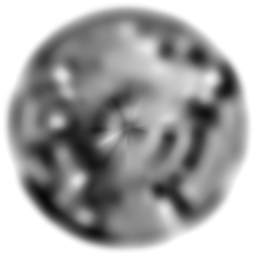

In [7]:
# Since the image is fixed we conveniently define the interpolation functions 
# to take into account the size of `img`.
function bispectral2cart(f; clamped = true) 
    I = pol2cart(bispectral2pol(f), size(img)...) 
    clamped ? clamp(I,0,1) : I
end

# approximation of the set E
f1 = cartesian2bispectral(img, E); 

# interpolation on a cartesian grid
img2 = pol2cart(bispectral2pol(f1), 256, 256)

convert(Image, bispectral2cart(f1))

Defining a bigger frequency set ($Q = 340$, $N=64$, so that $Q\times N = 21\,760$) however, allows for a good interpolation.

Does v agree with Q? true


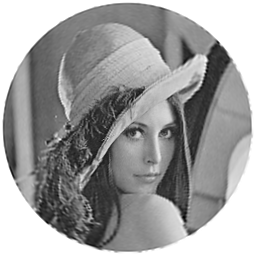

In [8]:
Q, N = 340, 64

max_ϱ = Q/4
step_ϱ = 1.

v = [ (4, 1:step_ϱ:max_ϱ) ];

Qv = sum([v[i][1]*length(v[i][2]) for i in 1:length(v)])

println("Does v agree with Q? $(Qv == Q)")

E = BispectralSet(N, v);

# approximation of the set E
f = cartesian2bispectral(img, E); 

convert(Image, bispectral2cart(f))

# Almost periodic interpolation

We start by considering the AP interpolation problem. For simplicity, we choose the set of frequencies $F = E$.

We then compute the the matrix operator $\mathcal J:\mathbb C^{Q}\otimes \mathbb C^N \to \mathbb C^{Q}\otimes \mathbb C^N$:
$$
	\mathcal J = \bigoplus_{n=0}^{N-1} \mathcal J_n ,
	\qquad
	(\mathcal J_n)_{j,k} = J_n^{\alpha_j-\omega_k}(\lambda_k\rho_j) \quad \text{for } 0\le j\le Q-1,\, 0\le k\le Q-1.
$$

Being block-diagonal, we only store the matrices $\mathcal J_n$ that compose $\mathcal J$.

In [9]:
BesselMatrix(E) ## Dry run for compilation
@time J = BesselMatrix(E)

println("Dimension of J is (N,Q,Q): $(size(J.matrix)==(N,Q,Q))")

  3.344504 seconds (16.34 M allocations: 794.574 MB, 10.42% gc time)
Dimension of J is (N,Q,Q): true


Finally, the AP interpolation of the test image is obtained as follows. This is a vector $a_f$ in $\mathbb C^Q\otimes\mathbb C^N$.

In [10]:
ap(f, J) ## Dry run for compilation
@time af = ap(f, J);

println("The size of af is (Q,N): $(size(af)==(Q,N))")

println()
println("Norm: $(norm(vec(af.f),2) |> x->round(x,2))")
println()

diff = norm(vec(af.f))/norm(vec(f.f)) |> x->round(x,2) #|> log10 |> x->round(x,1)
# println("L^2 norm of the resulting AP approximation $(round(Int,norm(vec(af.f),2)/norm(f.f,2)*100))% of the norm of the image")
println("The norm of the AP interpolation is $diff time bigger than that of the image")

  1.199101 seconds (46.53 k allocations: 231.552 MB, 2.61% gc time)
The size of af is (Q,N): true

Norm: 673258.51

The norm of the AP interpolation is 8402.35 time bigger than that of the image


We now visualize the magnitude of `af` by plotting (in logarithmic scale) the mean magnitude on the slices of the bispectral set.

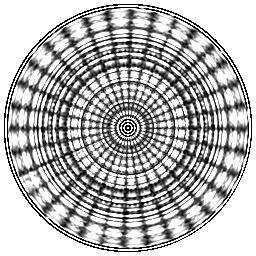

In [11]:
# Function to visualize the magnitude on the bispectral set
function bispectral2cart{N,T<:Complex}(af::BispInterpolation{N,T}) 
#     normalize(f::BispInterpolation) = 
#         BispInterpolation((f.f-minimum(f.f))/(maximum(f.f)-minimum(f.f)),f.E)
    normalize(x) = C.*x/maximum(C.*x) + (1-C)
    bispectral2cart(abs(af)) |> normalize
end

convert(Image,bispectral2cart(af))

To check the correctedness of the approximation, let us invert it and plot the result.

  0.259015 seconds (140.27 k allocations: 122.525 MB, 6.73% gc time)

Norm: 80.13

Maximal and minimum values of the resulting image: (0.004336717084014997,1.1642127443884918)


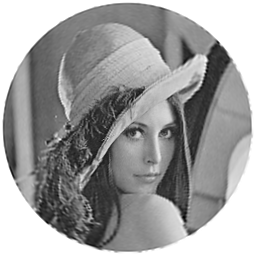

In [12]:
@time f2 = iap(af, J);

println()
println("Norm: $(norm(vec(f2.f),2) |> x->round(x,2))")
println()

extr = extrema(bispectral2cart(f2, clamped = false))
println("Maximal and minimum values of the resulting image: $extr")

convert(Image, bispectral2cart(f2))

## Comparison with direct computation

Let us check that this is indeed correct, by comparing the results obtained via the inverse interpolation `iap` and those given by a direct (although arguably naive) implementation of the operator $\text{ev}$ which `iap` encodes. Namely, we will directly compute
$$
    \text{ev}(v)_{i,j} = \sum_{k=0}^{Q-1} \sum_{m=0}^{M-1} v_{k,m} e^{i \lambda_k \rho_j \cos\left(\alpha_j-\omega_k + 2\pi\left(\frac n N- \frac m M\right)\right)}, \quad j=0,\ldots,Q-1, \,n=0,\ldots,N-1.
$$

In [13]:
Base.exp(x::Frequency) =  exp(im*x.λ*cos(angle(x)))

function Base.exp(x::Frequency, y::Frequency)
    ApApproximation.composition(x,y) |> exp
end

ev(af::BispInterpolation) = ev(af, af.E)
function ev{N,T}(af::BispInterpolation, F::BispectralSet{N,T})
    f = Array{Complex128, 2}(size(F)...)
    for n in 1:size(f,2), j in 1:size(f,1)
        f[j,n] = sum([ af.f[k,m]*exp(af.E[k,m],F[j,n]) for k in 1:size(af.E,1), m in 1:size(af.E,2) ])
    end
    BispInterpolation{N,Float64}(real(f), F)
end

ev (generic function with 2 methods)

Since this implementation is very slow, we will check this on a smaller bispectral set, using the `f1` we computed earlier.

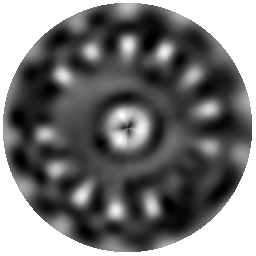

In [14]:
af1 = ap(f1)
convert(Image, bispectral2cart(af1))

In [15]:
ev(f1) # Dry run for compilation

tic() 
f1_ap = iap(f1)
t_ap = toq()

tic()
f1_ev = ev(f1)
t_ev = toq()

println("AP interpolation timing: $t_ap")
println("Direct computation timing: $t_ev")
println("Direct computation is $(round(Int,t_ev/t_ap)) times slower")
println("Relative L^2 error between the two: $(norm(vec(f1_ev.f - f1_ap.f) ,2)/norm(vec(f1_ap.f),2))")

AP interpolation timing: 0.035424653
Direct computation timing: 0.133811022
Direct computation is 4 times slower
Relative L^2 error between the two: 8.97166563989206e-15


## Effect of rototranslations

Although the above interpolation procedure yields a good approximation on the set $E$, the almost periodic function hereby obtained has very huge values outside of this set. This is evident when applying the effect of a translation on the frequencies `af`.

Translation of (15.0,26.0)
  0.289532 seconds (637.40 k allocations: 133.089 MB, 6.85% gc time)
Maximal and minimum values of the resulting image: (-1.358746694529572e6,963062.3801749656)

Norm: 7.03162659e6



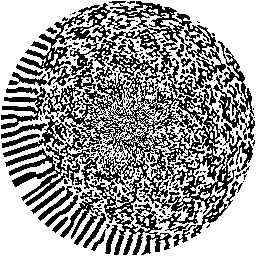

In [16]:
# Translation (in polar coordinates)
ρ = 30.
θ = pi/3
println("Translation of $(map(x->round(x,1),(ρ*cos(θ), ρ*sin(θ))))")
@time f2 = translate(af, ρ, θ) |> x -> iap(x, J);

extr = extrema(bispectral2cart(f2, clamped = false))
println("Maximal and minimum values of the resulting image: $extr")

println()
println("Norm: $(norm(vec(f2.f),2) |> x->round(x,2))")
println()

convert(Image, bispectral2cart(f2))

# Almost periodic approximation

To solve the above problem, the solution we propose is to look for an AP approximation of the starting image. That is, one considers a set of frequencies $F$ of size $P\times N$, where $P\le Q$, and looks for the AP function having frequencies in $F$ which better approximates the image on the set $E$. 

In [17]:
P, M = Q, N

max_λ = 2. 
step_λ = max_λ / (Q/4)

v = [ (4, step_λ:step_λ:max_λ) ];

Pv = sum([v[i][1]*length(v[i][2]) for i in 1:length(v)])
println("Does v agree with P? $(Pv == P)")

F = BispectralSet(N, v);

Does v agree with P? true


We have also the possibility of fixing weights on the frequencies of $F$. In this example, we want the image to be concentrated on low frequencies and so we use the following weight function, in this case for $\alpha = 100$,
$$
    w(\Lambda) = 
    \begin{cases}
    \frac \alpha{10} &\qquad \text{if } |\Lambda|\le 1\\
    \alpha &\qquad \text{if } 1<|\Lambda|\le\frac32\\
    100\alpha &\qquad \text{if } |\Lambda|>\frac32\\
    \end{cases}
$$

Generating Bessel matrices: 
  4.174151 seconds (21.64 M allocations: 1.191 GB, 9.24% gc time)
AP approximation: 
  2.009510 seconds (46.66 k allocations: 514.108 MB, 6.08% gc time)

Norm: 0.21

The norm of the AP interpolation is 0.0026 time bigger than that of the image
The norm of the AP approximation is 10^(6.5) time bigger than that of the AP interpolation


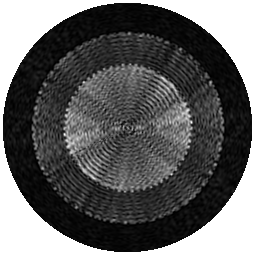

In [18]:
quarter = round(Int,size(F,1)/4)
α = 100
d = [   ones(2quarter)*α/10; 
        ones(quarter)*α; 
        ones(size(F,1) - 3*quarter)*1e2α; ]

println("Generating Bessel matrices: ")
@time J_int = BesselMatrix(E,F, weights = d);
println("AP approximation: ")
@time af_int = ap(f, F, J_int)

println()
println("Norm: $(norm(vec(af_int.f),2) |> x->round(x,2))")
println()

diff = norm(vec(af_int.f))/norm(vec(f.f)) |> x->round(x,4) 
println("The norm of the AP interpolation is $diff time bigger than that of the image")

diff = norm(vec(af.f))/norm(vec(af_int.f)) |> log10 |> x->round(x,1)
println("The norm of the AP approximation is 10^($diff) time bigger than that of the AP interpolation")

convert(Image, bispectral2cart(af_int))

Inverse AP approximation: 
  0.239190 seconds (45.39 k allocations: 118.450 MB, 7.79% gc time)

Norm: 79.84

Maximal and minimum values of the resulting image: (0.04032550897033768,1.1126731107194092)


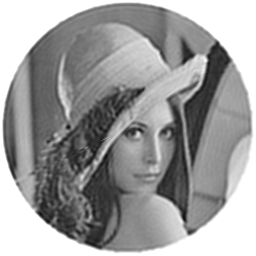

In [19]:
println("Inverse AP approximation: ")
@time f_int = iap(af_int, E, J_int)

println()
println("Norm: $(norm(vec(f_int.f),2) |> x->round(x,2))")
println()

extr = extrema(bispectral2cart(f_int, clamped = false))
println("Maximal and minimum values of the resulting image: $extr")

convert(Image, bispectral2cart(f_int))

The same translation test as before, now yields a correct result.

  0.246055 seconds (589.41 k allocations: 131.069 MB, 7.83% gc time)

Norm: 79.34

Maximal and minimum values of the resulting image: (-4.016381012881942,1.546994562147123)


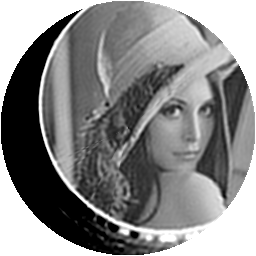

In [20]:
@time f_trans = translate(af_int, ρ, θ) |> x -> iap(x, E, J_int)

println()
println("Norm: $(norm(vec(f_trans.f),2) |> x->round(x,2))")
println()

extr = extrema(bispectral2cart(f_trans, clamped = false))
println("Maximal and minimum values of the resulting image: $extr")

convert(Image, bispectral2cart(f_trans))